## API REQUEST CALL AND DATA FILE CREATION

In [20]:
import requests
import json



fdic_data = requests.get("https://banks.data.fdic.gov/api/summary?filters=YEAR%3A%5B%222000%22%20TO%20%222019%22%5D&fields=STNAME%2CYEAR%2CINTINC%2CEINTEXP%2CNIM%2CNONII%2CNONIX%2CELNATR%2CITAXR%2CIGLSEC%2CITAX%2CEXTRA%2CNETINC&sort_by=YEAR&sort_order=DESC&limit=3000&offset=0&format=json&download=false&filename=data_file")
print(x.status_code)

data = fdic_data.json()
with open ('data.json', 'w') as fd:
    json.dump(data,fd)



200


## DROPING DATA INTO MONGODB

In [26]:

#!pip install pymongo
from pymongo import MongoClient

#Making Connection to MOngoDB
client = MongoClient("mongodb://localhost:27017/")

#Database
data_b = client["FDICDATABASE"]

#collection
Collection = data_b["fdic"]

#loading the json file
with open('data.json') as file:
    file_data = json.load(file)

#inserting the loaded file into the fdic collection
if isinstance(file_data, list):
    Collection.insert_many(file_data)
else:
    Collection.insert_one(file_data)
    
client.close()
    


## EXTRACTING DATA FROM MONGODB

In [ ]:
#mongodb connection
from pymongo import MongoClient
client = MongoClient("mongodb://localhost:27017/")
db = client['FDICDATABASE']
collection = db['fdic']
x = collection.find()
for fd_data in x:
    print(fd_data)
    

## CLEANING THE DATA

In [28]:
#normalizing the data
import pandas as pd
new_data = fd_data['data']
norm_data = pd.json_normalize(new_data)
#norm_data.head()

#checking for missing values
norm_data.isnull()


#drop the score column in the dataframe
fdic_data=norm_data.drop(['score'], axis =1)
fdic_data
print(fdic_data.columns)
#renaming my columns
fdic_data.columns = ['ITAX', 'EINTEXP', 'EXTRA', 'ELNATR', 'STNAME', 'INTINC', 'NETINC', 'NONIX', 'NIM', 'YEAR', 'ITAXR', 'IGLSEC', 'NONII', 'ID']
fdic_data.head()

print(fdic_data.dtypes)


Index(['data.ITAX', 'data.EINTEXP', 'data.EXTRA', 'data.ELNATR', 'data.STNAME',
       'data.INTINC', 'data.NETINC', 'data.NONIX', 'data.NIM', 'data.YEAR',
       'data.ITAXR', 'data.IGLSEC', 'data.NONII', 'data.ID'],
      dtype='object')
ITAX        int64
EINTEXP     int64
EXTRA       int64
ELNATR      int64
STNAME     object
INTINC      int64
NETINC      int64
NONIX       int64
NIM         int64
YEAR       object
ITAXR       int64
IGLSEC      int64
NONII       int64
ID         object
dtype: object


## VISUALIZATION OF DATA 

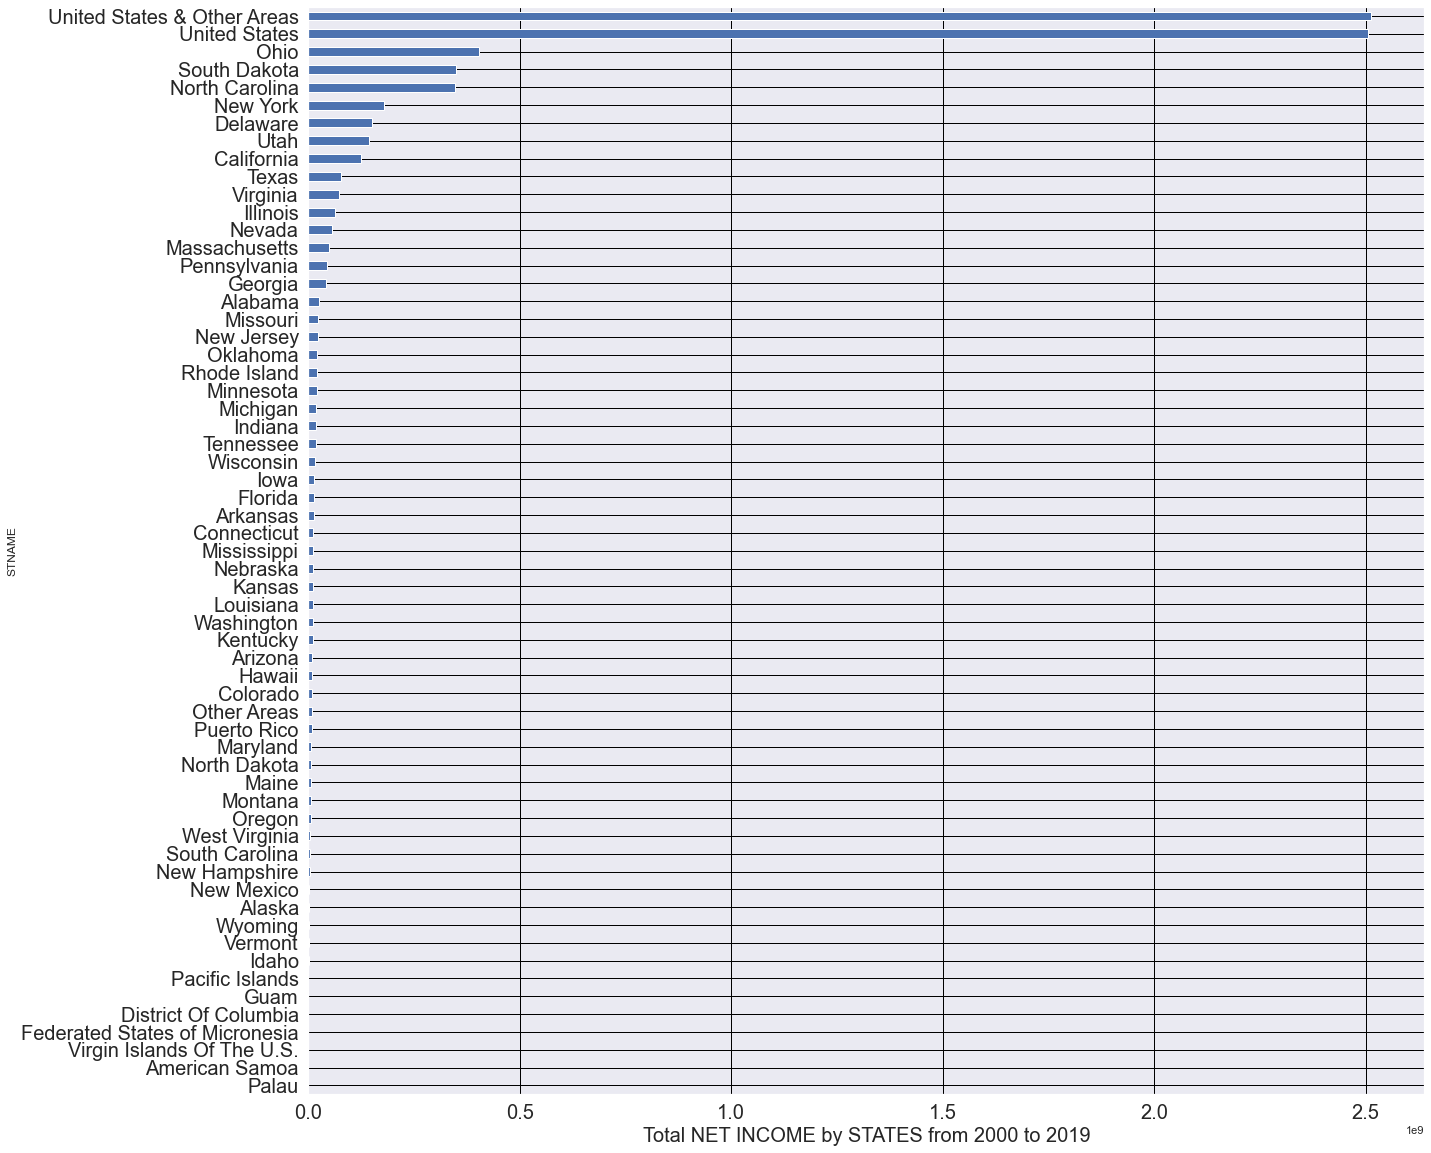

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes = True)

#vsualizing state and netincome
#fdic_data.hist()
#plt.show()

fig = plt.figure(figsize=(20,20))
states = fdic_data.groupby('STNAME')['NETINC'].sum().sort_values(ascending=True)
states.plot(kind="barh", fontsize = 20)
plt.grid(b=True, which='both', color='Black',linestyle='-')
plt.xlabel('Total NET INCOME by STATES from 2000 to 2019', fontsize = 20)
plt.show ()

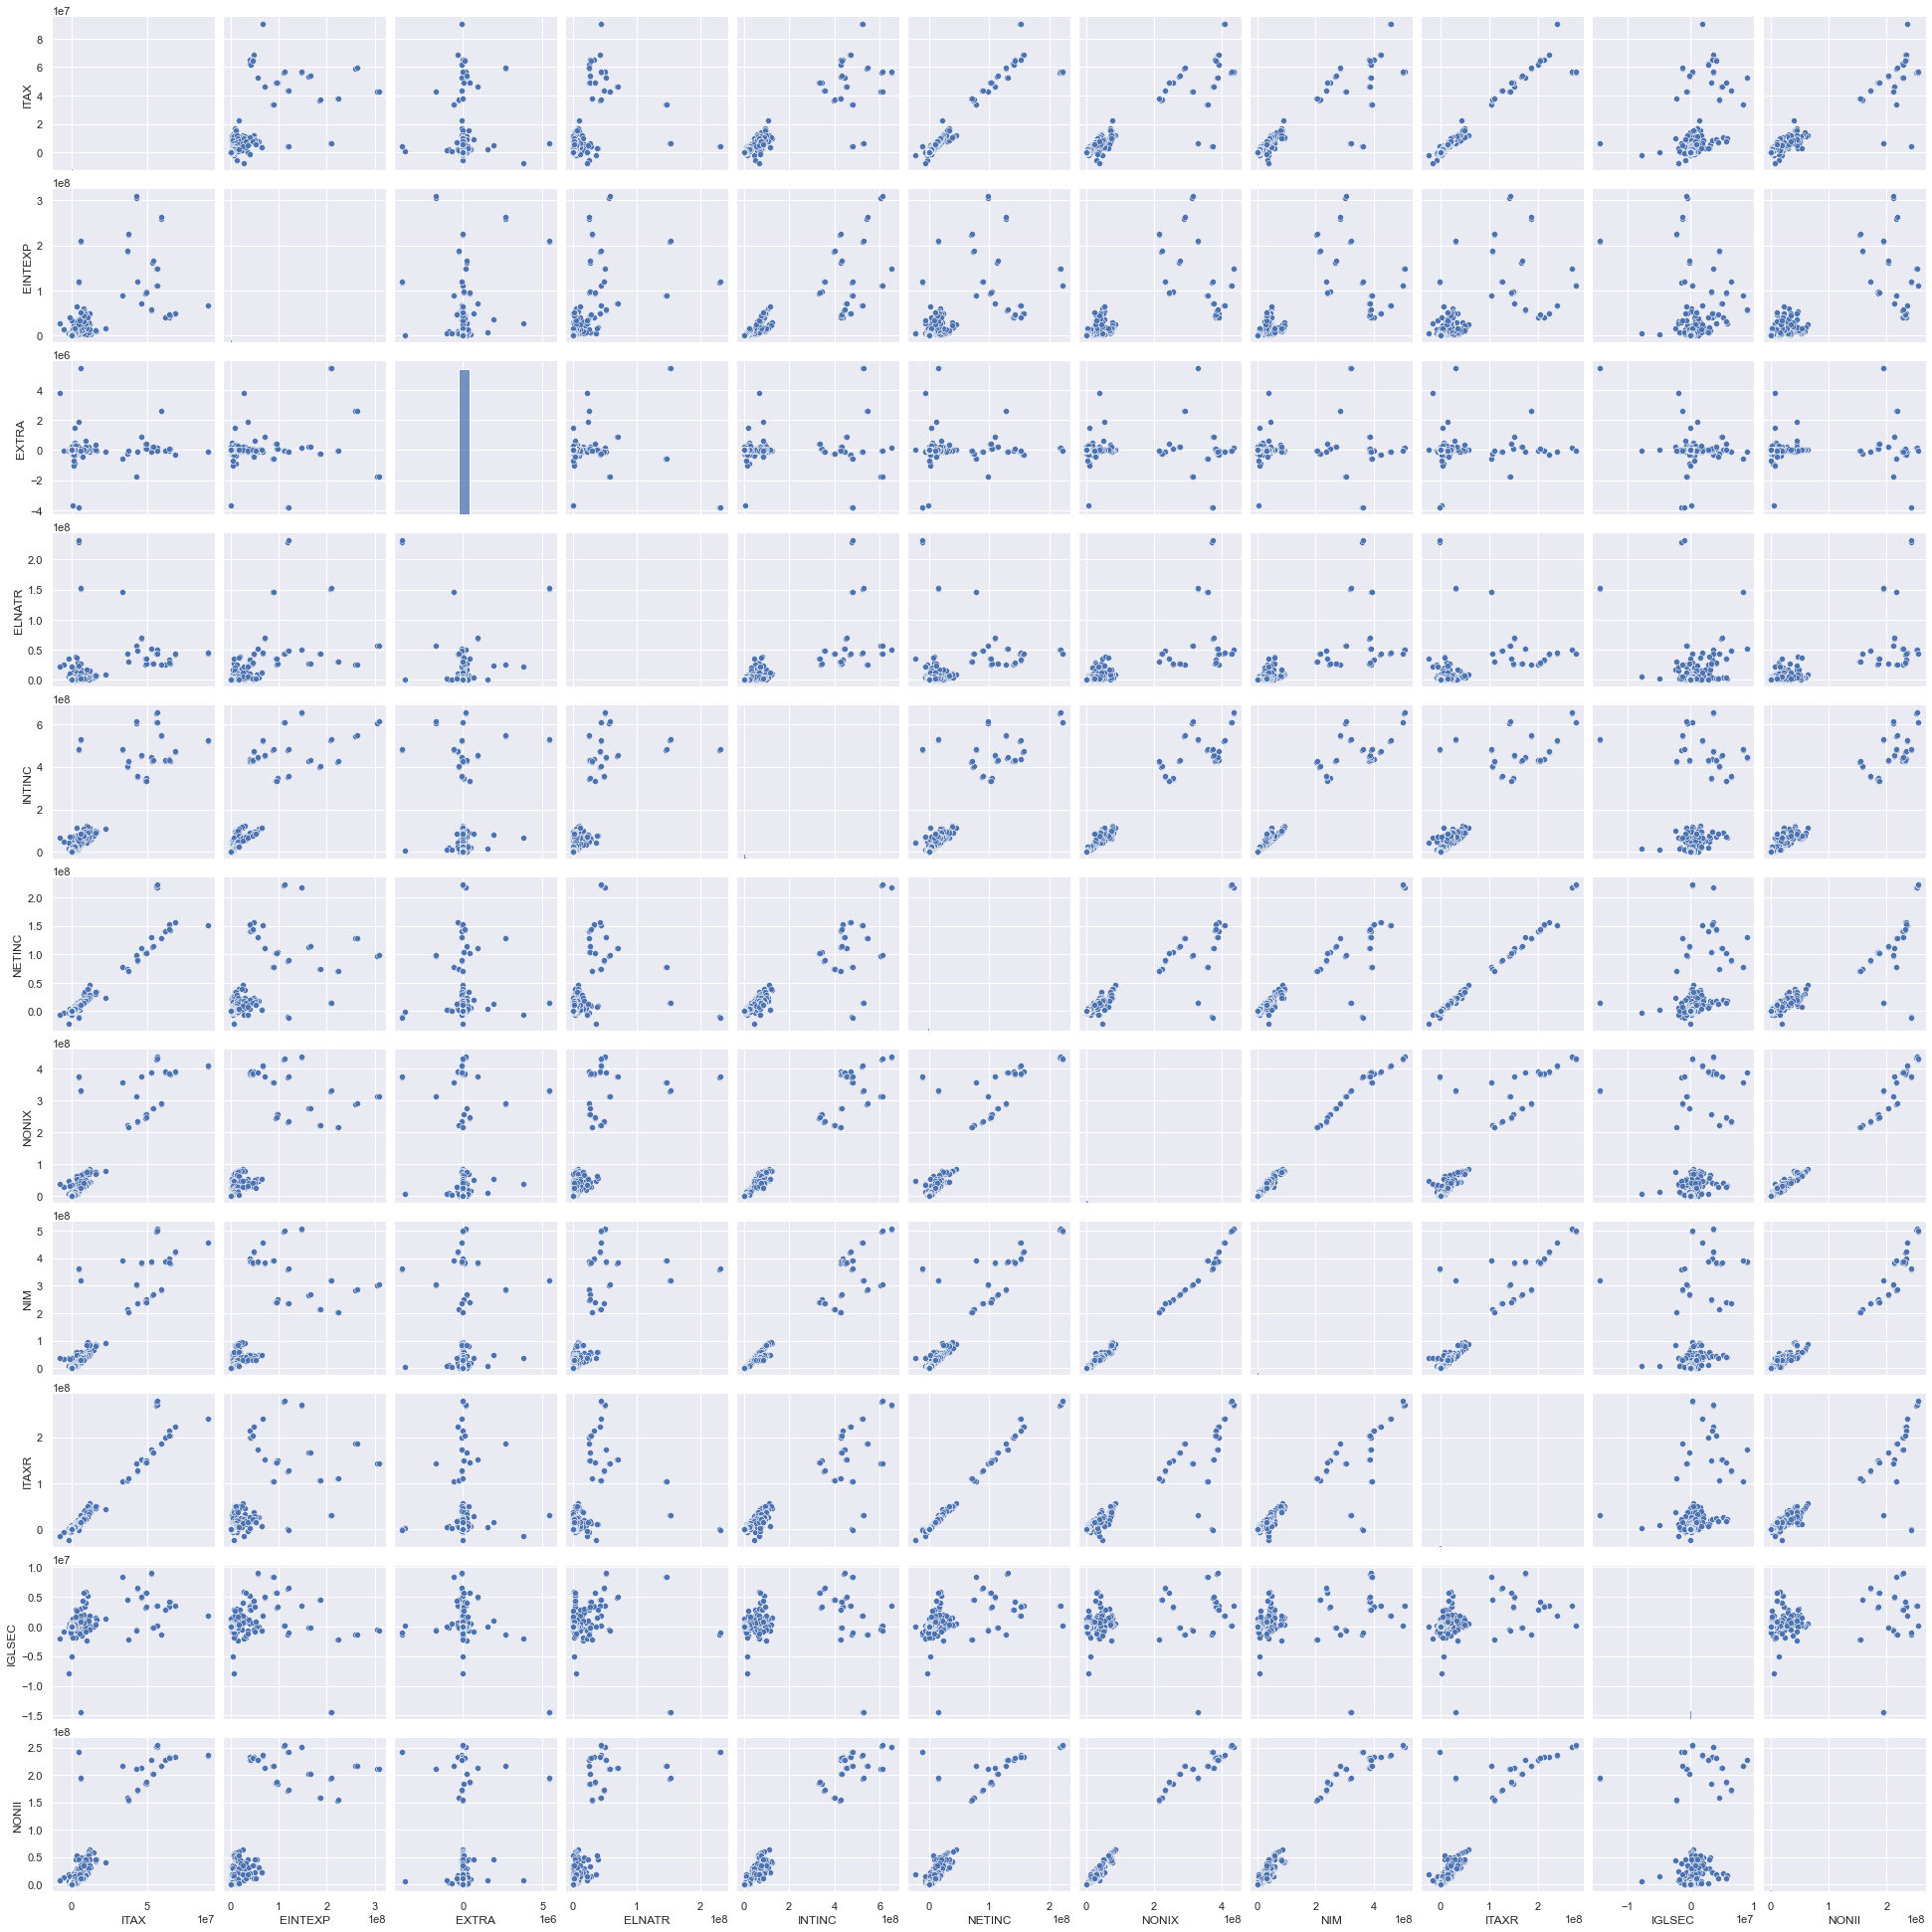

In [103]:

cols = ['ITAX', 'EINTEXP', 'EXTRA', 'ELNATR', 'STNAME', 'INTINC', 'NETINC', 'NONIX', 'NIM', 'YEAR', 'ITAXR', 'IGLSEC', 'NONII', 'ID']
sns.pairplot(fdic_data[cols])

## CONVERTING INTO A CSV FILE FOR POSTGRESSQL

In [24]:
#conerting the data into csv
fdic_data.to_csv(r'C:\Users\mamma\Documents\fdic_dataframe.csv', index = False, header = True)
#print(fdic_data)

## CONNECTING AND DROPPING DATA INTO POSTGRESSQL

In [132]:
#!pip install psycopg2
import psycopg2 

#establish a connection to database
con = psycopg2.connect(database = "GROUPJDAP",
                      user = 'postgres',
                      password = '1234',
                      host ='127.0.0.1',
                      port = '5432')

con.autocommit = True
cursor = con.cursor()

#creating database 
psql = '''CREATE TABLE FDICDATABASE(ITAX int, EINTEXP int, EXTRA int, ELNATR int, STNAME text, INTINC int, NETINC int, NONIX int, NIM int, YEAR char(20), ITAXR int, IGLSEC int, NONII int, ID varchar(30));'''

cursor.execute(psql)




In [133]:
#copying data from csv file
psql2 = '''COPY fdicdatabase(ITAX, EINTEXP, EXTRA , ELNATR, STNAME, INTINC, NETINC, NONIX, NIM, YEAR, ITAXR, IGLSEC, NONII, ID)
FROM 'C:/temp/fdic_dataframe.csv'
DELIMITER ',' 
CSV HEADER;'''

cursor.execute(psql2)



In [ ]:
psql3 = '''select * from fdicdatabase'''
cursor.execute(psql3)
for i in cursor.fetchall():
    print(i)
  
con.commit()


## INSERTING OTHER GROUP MEMEBERS DATASET INTO PSTGRESQL

In [ ]:
#inserting the cattle dataset from akinwale

cattlesql = '''CREATE TABLE CATTLEDATABASE(index int, YEAR int, LOCATION text, CATTLE_BREED_TYPE text,  CATTLE_GENDER text, CATTLE_AGE_0_6 int, CATTLE_AGE_6_6 int, CATTLE_AGE_6_12 int, CATTLE_AGE_12_18 int, CATTLE_AGE_18_24 int, CATTLE_AGE_24_30 int, CATTLE_AGE_30_36 int, CATTLE_AGE_36_PLUS int);'''

cursor.execute(cattlesql)

#copying data from csv file
cattlesql2 = '''COPY cattledatabase(index, YEAR, LOCATION, CATTLE_BREED_TYPE, CATTLE_GENDER, CATTLE_AGE_0_6, CATTLE_AGE_6_6, CATTLE_AGE_6_12, CATTLE_AGE_12_18, CATTLE_AGE_18_24, CATTLE_AGE_24_30, CATTLE_AGE_30_36, CATTLE_AGE_36_PLUS)
FROM 'C:/temp/akinwale_cattledata.csv'
DELIMITER ',' 
CSV HEADER;'''


cursor.execute(cattlesql2)

cattlesql3 = '''select * from cattledatabase'''
cursor.execute(cattlesql3)
for i in cursor.fetchall():
    print(i)
  
con.commit()


In [ ]:
#inserting the healthcare dataset from Jomol

healthcaresql = '''CREATE TABLE HEALTHCAREDATABASE(Year int, LocationAbbr text, LocationDesc text, DataSource text, PriorityArea1 text, PriorityArea2 text, PriorityArea3 text, PriorityArea4 text, Category text, Topic text, Indicator text, Data_Value_Type text, Data_Value_Unit text, Data_Value float, Data_Value_Alt float, LowConfidenceLimit float, HighConfidenceLimit float, Break_Out_Category text, Break_Out varchar(30), CategoryId varchar(30), TopicId varchar(30), IndicatorID varchar(30), Data_Value_TypeID text, BreakOutCategoryId varchar(30), BreakOutId varchar(30), LocationID int);'''

cursor.execute(healthcaresql)

#copying data from csv file
healthcaresql2 = '''COPY healthcaredatabase(Year, LocationAbbr, LocationDesc, DataSource, PriorityArea1, PriorityArea2, PriorityArea3, PriorityArea4, Category, Topic, Indicator, Data_Value_Type, Data_Value_Unit, Data_Value, Data_Value_Alt, LowConfidenceLimit, HighConfidenceLimit, Break_Out_Category, Break_Out, CategoryId, TopicId, IndicatorID, Data_Value_TypeID, BreakOutCategoryId, BreakOutId, LocationID)
FROM 'C:/temp/Healthcare.csv'
DELIMITER ',' 
CSV HEADER;'''


cursor.execute(healthcaresql2)

healthcaresql3 = '''select * from healthcaredatabase'''
cursor.execute(healthcaresql3)
for i in cursor.fetchall():
    print(i)
  
con.commit()


In [ ]:
#inserting the Food inspection dataset for Deep

foodinspectsql = '''CREATE TABLE FOODINSPECTDATABASE(Inspection_ID int, DBA_Name text, AKA_Name text, License int, Facility_Type text, Risk text, Address text, City text, State text, Zip int, Inspection_Date int, Inspection_Type text, Results text);'''

cursor.execute(foodinspectsql)

#copying data from csv file
foodinspectsql2 = '''COPY foodinspectdatabase(Inspection_ID, DBA_Name, AKA_Name, License , Facility_Type, Risk, Address, City, State, Zip, Inspection_Date, Inspection_Type, Results)
FROM 'C:/temp/Food_Inspections_New2_converted.csv'
DELIMITER ',' 
CSV HEADER;'''


cursor.execute(foodinspectsql2)

foodinspectsql3 = '''select * from foodinspectdatabase'''
cursor.execute(foodinspectsql3)
for i in cursor.fetchall():
    print(i)
  
con.commit()
con.close()


## JOINNING OUR TABLES

In [ ]:
import psycopg2 
#establish a connection to database
con = psycopg2.connect(database = "GROUPJDAP",
                      user = 'postgres',
                      password = '1234',
                      host ='127.0.0.1',
                      port = '5432')

con.autocommit = True
cursor = con.cursor()
#INNER JOIN foodinspectdatabase fid ON fd.year:: integer = fid.inspection_date
groupdata = '''SELECT *
FROM cattledatabase cd
INNER JOIN fdicdatabase fd ON cd.year = fd.year:: integer
;'''

cursor.execute(groupdata)
results = cursor.fetchall()
for i in results:
    print(i)
con.commit()
con.close()


In [ ]:
#joining food inspection and health care datasets/.
import psycopg2 
#establish a connection to database
con = psycopg2.connect(database = "GROUPJDAP",
                      user = 'postgres',
                      password = '1234',
                      host ='127.0.0.1',
                      port = '5432')

con.autocommit = True
cursor = con.cursor()

groupdata = '''SELECT *
FROM foodinspectdatabase fid
INNER JOIN healthcaredatabase hcd ON fid.inspection_date = hcd.year
;'''

cursor.execute(groupdata)
results = cursor.fetchall()
for i in results:
    print(i)
con.commit()
con.close()